In [5]:
"""
Implementation of trend following strategy by using APO
"""

'\nImplementation of trend following strategy by using APO\n'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data

In [7]:
# we create dataset first
# we use five years data from amazon for comparison
try:
    data_amzn = pd.read_pickle('amzn_data.pkl')
except:
    data_amzn = data.DataReader("AMZN",'yahoo','2015-01-01','2020-01-01')
    data_amzn.to_pickle('amzn_data.pkl')
data_amzn

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,15.737500,15.348000,15.629000,15.426000,55664000,15.426000
2015-01-05,15.419000,15.042500,15.350500,15.109500,55484000,15.109500
2015-01-06,15.150000,14.619000,15.112000,14.764500,70380000,14.764500
2015-01-07,15.064000,14.766500,14.875000,14.921000,52806000,14.921000
2015-01-08,15.157000,14.805500,15.016000,15.023000,61768000,15.023000
...,...,...,...,...,...,...
2019-12-24,89.778503,89.378998,89.690498,89.460503,17626000,89.460503
2019-12-26,93.523003,89.974998,90.050499,93.438499,120108000,93.438499
2019-12-27,95.070000,93.300499,94.146004,93.489998,123732000,93.489998


In [8]:
# the first part is almost the same as the mean-reversion-strategy

# define the window_size for fast_ema and slow_ema
# for fast_ema, it is 10 days
fast = 10
f_factor = 2 / (fast+1)
ema_fast = 0
ema_fast_values = []

slow = 40 # 40 days for slow_ema
s_factor = 2 / (slow+1)
ema_slow = 0
ema_slow_values = []
apo_values = [] # we save it for buying / selling signals

In [9]:
# we save some variables for storing orders, positions, and profit & loss
orders = [] 
# -1: sell order
# 1: buy order
# 0: neutral

positions = []
# -1: short
# 1: long
# 0: netural

# open value - closed value
# sum of open pnl and closed pnl (lock-in profits - realized)
pnls = []

# we record the last buy/sell price to prevent overtrading
# we don't want to buy/sell just around the last buy/sell trade to ensure profits
last_buy_price = 0
last_sell_price = 0

# current position
position = 0

# summation quantity since last no position
buy_sum_qty = 0
sell_sum_qty = 0

buy_sum_price_qty = 0
sell_sum_price_qty = 0

# record open and closed pnls
open_pnls = 0
closed_pnls = 0

In [10]:
# we set up threshold for enter positions and the minimum price change since the last trade
apo_buy_entry = 5 # but this time, the buy/sell entry swaps
apo_sell_entry = -5
min_price_movement = 5 # we use it prevent overtrading
num_shares = 10 # number of shares we will buy/sell at each trade
min_profit_to_close = 5*num_shares # if the profits > 5, regardless of apo, we exit the position

In [11]:
close = data_amzn['Close']
# we update fast and slow ema
for close_price in close:
    # chech whether it is the first date in the dataframe
    if ema_fast == 0:
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = f_factor * close_price + (1-f_factor) * ema_fast
        ema_slow = s_factor * close_price + (1-s_factor) * ema_slow
    # we append the ema values
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    
    # we calculate apo and append it to apo values list
    apo = ema_fast-ema_slow
    apo_values.append(apo)
    # we define our sell condition:
    # 1. if now apo <-5 and the absolute difference between the price and previous sell price > min_price_movement
    # we sell it, because we believe the trend of going down
    # 2. we have entered a long position, and now the apo changes its sign or we can lock in our profits 
    # (open_pnls > some amount)
    if (apo < apo_sell_entry and abs(close_price - last_sell_price) > min_price_movement) or \
    (position > 0 and (apo <= 0 or open_pnls > min_profit_to_close)):
        orders.append(-1)
        last_sell_price = close_price
        position -= num_shares
        sell_sum_qty += num_shares
        sell_sum_price_qty += num_shares*close_price
        print("We sell", num_shares, "@",close_price)
        print("Position:",position)
    elif (apo > apo_buy_entry and abs(close_price - last_buy_price) > min_price_movement) or \
    (position < 0 and (apo >= 0 or open_pnls > min_profit_to_close)):
        orders.append(1)
        last_buy_price = close_price
        position += num_shares
        buy_sum_qty += num_shares
        buy_sum_price_qty += close_price * num_shares
        print("We buy", num_shares, "@",close_price)
        print("Position:",position)
    else: # we maintain the neutral position
        orders.append(0)
    positions.append(position)
    
    # for pnls, we don't ened to change
    # since it only relates to positions
    # open pnls: pnls at current stage
    # so we reset it in every loop
    open_pnls = 0
    # we also need to update open and close pnls
    if position > 0:
        # we need to minus some closed pnls if position > 0 but sell_qty > 0
        # because that means our position is long, but we have done some selling against this trade
        # we will minus the closed pnls
        if sell_sum_qty > 0:
            # we use an average price difference for calculation
            open_pnls += sell_sum_qty*(sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # then we set the remaining to open pnls with respect to market price
        
        # why do we use (sell_sum_qty - buy_sum_qty): we want the unrealized buy_sum_qty
        # why do we use (close_price - buy_sum_price / buy_sum_qty):
        # because we want to calculate the profits if we close at current price
        # we want to sell at close_price because we have long position
        open_pnls += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    
    # we now look at the case for short position
    elif position < 0:
        # that means we have some realized buy orders
        if buy_sum_qty > 0:
            open_pnls += buy_sum_qty * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        
        # we want to calculate the unrealized buy open pnls
        
        # why do we use (sell_sum_price_qty / sell_sum_qty-open_price):
        # now out position is short, and we want to buy back at the current open_price 
        open_pnls += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty-close_price)
    else:
        # the position is 0, we just update close_pnls
        # open_pnls is 0. we can directly use sell_sum_price_qty - buy_sum_price_qty
        closed_pnls += sell_sum_price_qty - buy_sum_price_qty
        
        # and we reset the sum_price_qty 
        buy_sum_price_qty = 0
        sell_sum_price_qty = 0
        
        buy_sum_qty = 0
        sell_sum_qty = 0
        
        last_buy_price = 0
        last_sell_price = 0
    print("OpenPnL: ", open_pnls, " ClosedPnL: ", closed_pnls)
    print("Totl PnL:",closed_pnls+open_pnls)
    pnls.append(closed_pnls+open_pnls)
            
    

OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  

OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  

Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  

OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  -17.800064086914062
Totl PnL: -17.800064086914062
OpenPnL:  0  ClosedPnL:  

OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPnL:  0  ClosedPnL:  65.92491149902344
Totl PnL: 65.92491149902344
OpenPn

In [12]:
# it seems that we still benefit from trend_following_apo strategy, and we earn 65.9249
# we visualize it
# now we want to visualize the result
data_amzn['Fast_EMA'] = pd.Series(ema_fast_values,index = data_amzn.index)
data_amzn['Slow_EMA'] = pd.Series(ema_slow_values,index = data_amzn.index)
data_amzn['APO'] = pd.Series(apo_values,index = data_amzn.index)
data_amzn['Orders'] = pd.Series(orders,index = data_amzn.index)
data_amzn['Position'] = pd.Series(positions,index = data_amzn.index)
data_amzn['PnL'] = pd.Series(pnls,index = data_amzn.index)
data_amzn


,High,Low,Open,Close,Volume,Adj Close,Fast_EMA,Slow_EMA,APO,Orders,Position,PnL
Date,,,,,,,,,,,,
2015-01-02,15.737500,15.348000,15.629000,15.426000,55664000,15.426000,15.426000,15.426000,0.000000,0,0,0.000000
2015-01-05,15.419000,15.042500,15.350500,15.109500,55484000,15.109500,15.368454,15.410561,-0.042106,0,0,0.000000
2015-01-06,15.150000,14.619000,15.112000,14.764500,70380000,14.764500,15.258644,15.379045,-0.120401,0,0,0.000000
2015-01-07,15.064000,14.766500,14.875000,14.921000,52806000,14.921000,15.197254,15.356702,-0.159447,0,0,0.000000
2015-01-08,15.157000,14.805500,15.016000,15.023000,61768000,15.023000,15.165572,15.340424,-0.174852,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,89.778503,89.378998,89.690498,89.460503,17626000,89.460503,89.032167,88.628376,0.403791,0,0,65.924911
2019-12-26,93.523003,89.974998,90.050499,93.438499,120108000,93.438499,89.833318,88.863016,0.970302,0,0,65.924911
2019-12-27,95.070000,93.300499,94.146004,93.489998,123732000,93.489998,90.498169,89.088722,1.409447,0,0,65.924911


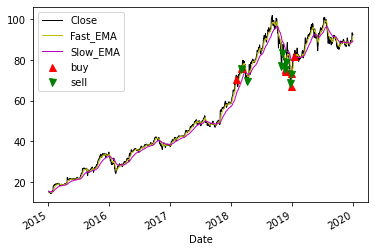

In [13]:
data_amzn['Close'].plot(color = 'k',lw = 1)
data_amzn['Fast_EMA'].plot(color = 'y',lw = 1)
data_amzn['Slow_EMA'].plot(color = 'm',lw = 1)
# we show our order
plt.plot(data_amzn.loc[data_amzn.Orders == 1].index, data_amzn.Close[data_amzn.Orders == 1],lw = 0,label = 'buy', markersize = 7,marker = '^',color = 'r')
plt.plot(data_amzn.loc[data_amzn.Orders == -1].index, data_amzn.Close[data_amzn.Orders == -1],lw = 0,label = 'sell', markersize = 7,marker = 'v',color = 'g')
plt.legend()

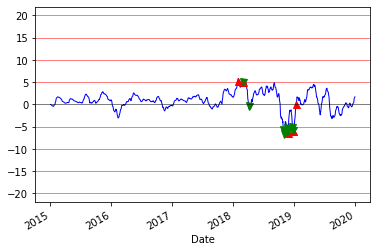

In [14]:
# if we compare this graph with mean-reversion-strategy, we will find that the buy/sell behaviors 
# gather in the same area
# but with a little more modification

# we also display the apo values and buy/sell orders
data_amzn['APO'].plot(color ='b',lw = 1)
plt.plot(data_amzn.loc[data_amzn.Orders == 1].index, data_amzn.APO[data_amzn.Orders == 1],color = 'r',marker = '^',markersize = 7,lw = 0, label = 'buy')
plt.plot(data_amzn.loc[data_amzn.Orders == -1].index, data_amzn.APO[data_amzn.Orders == -1],color = 'g',marker = 'v',markersize = 7,lw = 0, label = 'sell')

# we draw some horizontal lines to see where to buy and where to sell more clearly
plt.axhline(y = 0, lw = 0.5, color = 'k')

for i in range(apo_buy_entry, apo_buy_entry*5,apo_buy_entry):
    plt.axhline(y = i,lw = 0.5, color = 'r')

    
for i in range(apo_sell_entry, apo_sell_entry*5,apo_sell_entry):
    plt.axhline(y = i,lw = 0.5, color = 'g')
# we can see that the apo doesn't change much
# as shown in the graph 
# so the graph doesn't exhibit one of the important features of mean_reversion_apo: 
# we execute buy orders for negative apo, and sell orders for positive apo

# but it exhibits another important point: some sell orders for negative apo, and 
# buy orders for positive apo
# one of the reason might be that we have accumulated enough lock-in profits

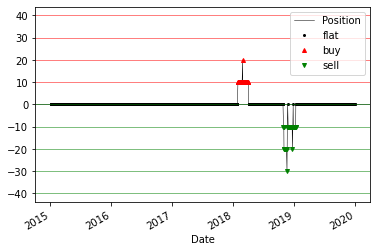

In [15]:
# to prove our guess, we draw the position graph
data_amzn['Position'].plot(color = 'k',lw = 0.5)
plt.plot(data_amzn[data_amzn.Position == 0].index, data_amzn.Position[data_amzn.Position == 0],marker = '.',markersize = 4,color = 'k',lw = 0, label = 'flat')
plt.plot(data_amzn[data_amzn.Position > 0].index, data_amzn.Position[data_amzn.Position >0],marker = '^',markersize = 4,color = 'r',lw = 0, label = 'buy')
plt.plot(data_amzn[data_amzn.Position < 0].index, data_amzn.Position[data_amzn.Position <0],marker = 'v',markersize = 4,color = 'g',lw = 0, label = 'sell')

plt.axhline(y = 0, lw = 0.5, color = 'k')

for i in range(num_shares, num_shares*5,num_shares):
    plt.axhline(y = i,lw = 0.5, color = 'r')

for i in range(0, -num_shares*5,-num_shares):
    plt.axhline(y = i,lw = 0.5, color = 'g')
    
plt.legend()


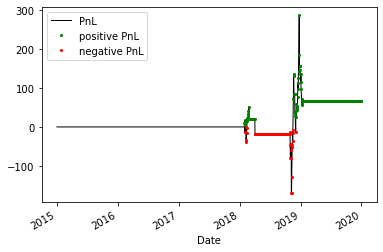

In [16]:
# comparing with the mean-reversion strategy, we can see that we just swap the buy/sell behaviors
# but we can still get profits.

# we draw our pnl graph
data_amzn['PnL'].plot(color = 'k',lw = 1)
# green represents positive pnl
plt.plot(data_amzn[data_amzn.PnL > 0].index, data_amzn.PnL[data_amzn.PnL> 0],marker = '.',color = 'g',lw = 0,markersize = 4,label = 'positive PnL')
plt.plot(data_amzn[data_amzn.PnL < 0].index, data_amzn.PnL[data_amzn.PnL< 0],marker = '.',color = 'r',lw = 0,markersize = 4,label = 'negative PnL')
plt.legend()


In [ ]:
# although trend-following strategy makes less money compared to mean-reversion strategy
# we still earn money in this case